In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from response import response_torch, response_legacy_torch
from typing import Callable, List, Tuple, Optional

-----------------
## Build neural network with pytorch

In [2]:
# get device for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [203]:
import torch.optim as optim
import matplotlib.pyplot as plt

def fx(x, a, b, c, d):
    return a*x**2 + b*np.sin(c*d)

class NN(nn.Module):
    def __init__(self, data_size=50):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(data_size, 256), # input raw data points
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4) # output [a, b] parameters
        )

    def forward(self, data_points):
        return self.network(data_points) # Direct data -> Parameters
    
def physics_loss(network, data_batch, x_values):
    predicted_params = network(data_batch) # [a, b] for this dataset
    a, b, c, d = predicted_params[:, 0], predicted_params[:, 1], predicted_params[:, 2], predicted_params[:, 3]

    # constraints
    fitted_curve = a.unsqueeze(1) / torch.cos(x_values**2) + b.unsqueeze(1)*torch.sin(torch.pi*c*x_values)*torch.exp(-d*x_values)
    fit_residual = fitted_curve - data_batch
    return torch.mean(fit_residual**2)

def generate_synthetic_quadratic_data(batch_size=32, data_size=50, noise_level=0.1):
    true_a      = torch.randn(batch_size, 1) * 2
    true_b      = torch.randn(batch_size, 1) * 5
    true_c      = torch.randn(batch_size, 1) * 0.2
    true_d      = torch.randn(batch_size, 1) * 0.3
    x_vals      = torch.linspace(-2, 2, data_size)

    y_data      = true_a /torch.cos(x_vals**2) + true_b*torch.sin(torch.pi*true_c*x_vals)*torch.exp(-true_d*x_vals) + torch.randn(batch_size, data_size) * noise_level
    return y_data, x_vals, true_a.squeeze(), true_b.squeeze(), true_c.squeeze(), true_d.squeeze()

def get_corresponding_x_values(data_size=50):
    return torch.linspace(-2,2, data_size)

def train(epochs=1000, batch_size=32, data_size=50):
    model   = NN(data_size=data_size)
    optimizer = optim.Adam(model.parameters(), lr=5*1e-5)

    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        synthetic_data, x_vals, true_a, true_b, _, _ = generate_synthetic_quadratic_data(batch_size=batch_size, data_size=data_size, noise_level=0.1)

        loss = physics_loss(network=model, data_batch=synthetic_data, x_values=x_vals)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if epoch%100==0:
            print(f"Epoch {epoch}, Loss : {loss.item():.6f}")
        if (loss > 1E3) and (epoch>10):
            break
        
    return model, losses

def test_model(model, data_size=50, Ndata=10):
    model.eval()

    for i in range(Ndata):
        test_data, x_vals, true_a, true_b, true_c, true_d = generate_synthetic_quadratic_data(batch_size=1, data_size=data_size)
        with torch.no_grad():
            predicted_params    = model(test_data)
            pred_a, pred_b, pred_c, pred_d      = predicted_params[0, 0].item(), predicted_params[0, 1].item(), predicted_params[0, 2].item(), predicted_params[0, 3].item()

        print(f"True parameters: a={true_a.item():.3f}, b={true_b.item():.3f}")
        print(f"Predicted parameters: a={pred_a:.3f}, b={pred_b:.3f}, b={pred_b:.3f}, c={pred_c:.3f}, d={pred_d:.3f}")
        
        # Plot results
        plt.figure(figsize=(10, 6))
        
        x_plot = torch.linspace(-2, 2, 100)
        y_true = true_a / torch.cos(x_plot**2) + true_b*torch.sin(torch.pi*true_c*x_plot)*torch.exp(-true_d*x_plot)
        y_pred = pred_a / torch.cos(x_plot**2) + pred_b*torch.sin(torch.pi*pred_c*x_plot)*torch.exp(-pred_d*x_plot)
        
        plt.scatter(x_vals, test_data[0], alpha=0.6, label='Data points')
        plt.plot(x_plot, y_true, 'r-', label=f'True: {true_a.item():.2f}/cos(x²) + {true_b.item():.2f}*sin($\pi$*{true_c.item():.2f}*x)*exp({true_d.item():.2f}x)')
        plt.plot(x_plot, y_pred, 'b--', label=f'Predicted: {pred_a:.2f}/cos(x²) + {pred_b:.2f}*sin($\pi$*{pred_c:.2f}*x)*exp({pred_d:.2f}x)')
        plt.legend()
        plt.title('PINN Fit Replacement Results')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True)
        plt.savefig('/'.join(['DATASET_and_OUTPUT/test_nnfitter', f'test_nnfitter_data{i}.png']))
        # plt.close()
        plt.show()

<>:93: SyntaxWarning: invalid escape sequence '\p'
<>:94: SyntaxWarning: invalid escape sequence '\p'
<>:93: SyntaxWarning: invalid escape sequence '\p'
<>:94: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2837006/1973681032.py:93: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_plot, y_true, 'r-', label=f'True: {true_a.item():.2f}/cos(x²) + {true_b.item():.2f}*sin($\pi$*{true_c.item():.2f}*x)*exp({true_d.item():.2f}x)')
/tmp/ipykernel_2837006/1973681032.py:94: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_plot, y_pred, 'b--', label=f'Predicted: {pred_a:.2f}/cos(x²) + {pred_b:.2f}*sin($\pi$*{pred_c:.2f}*x)*exp({pred_d:.2f}x)')


In [204]:
model, losses = train(epochs=2000, batch_size=100, data_size=100)

Epoch 0, Loss : 71.194313
Epoch 100, Loss : 11.312364
Epoch 200, Loss : 13.216664
Epoch 300, Loss : 9.040720
Epoch 400, Loss : 6.592792
Epoch 500, Loss : 7.015668
Epoch 600, Loss : 2.598564
Epoch 700, Loss : 2.279913
Epoch 800, Loss : 1.986667
Epoch 900, Loss : 1.601891
Epoch 1000, Loss : 1.560370
Epoch 1100, Loss : 1.068378
Epoch 1200, Loss : 1.269697
Epoch 1300, Loss : 2.218865
Epoch 1400, Loss : 1.487822
Epoch 1500, Loss : 1.673145
Epoch 1600, Loss : 0.590299
Epoch 1700, Loss : 3.563059
Epoch 1800, Loss : 2.360429
Epoch 1900, Loss : 5.666403


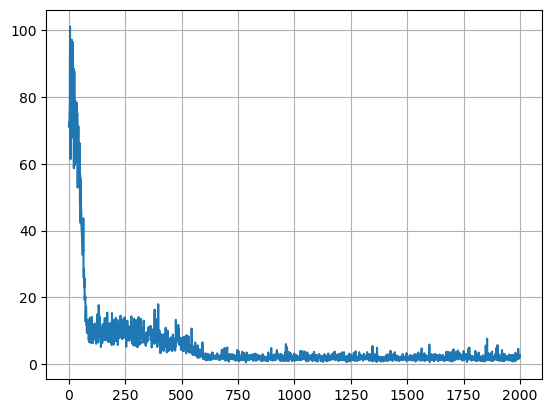

In [205]:
plt.figure()
plt.plot(losses, '-')
# plt.ylim([0, 0.04])
plt.grid()
plt.show()

True parameters: a=1.342, b=2.173
Predicted parameters: a=1.335, b=2.460, b=2.460, c=-0.215, d=0.021


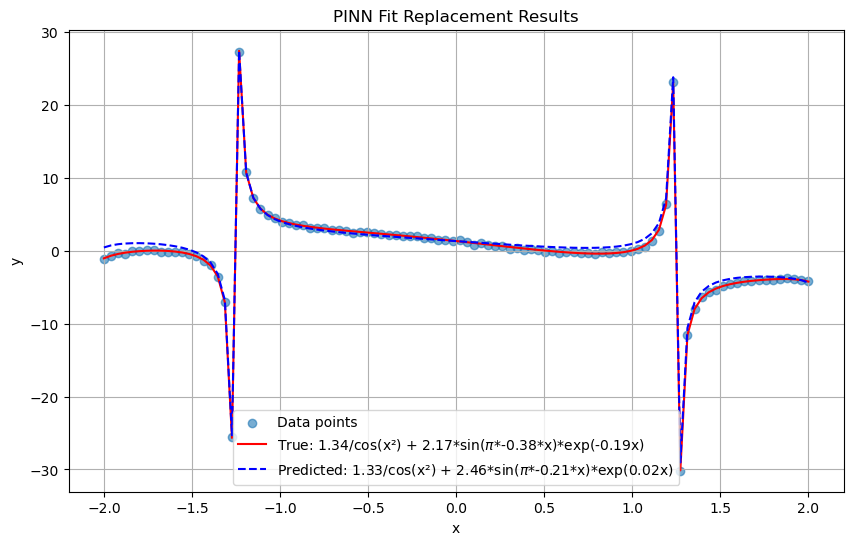

True parameters: a=1.341, b=-3.461
Predicted parameters: a=1.287, b=3.305, b=3.305, c=-0.218, d=0.012


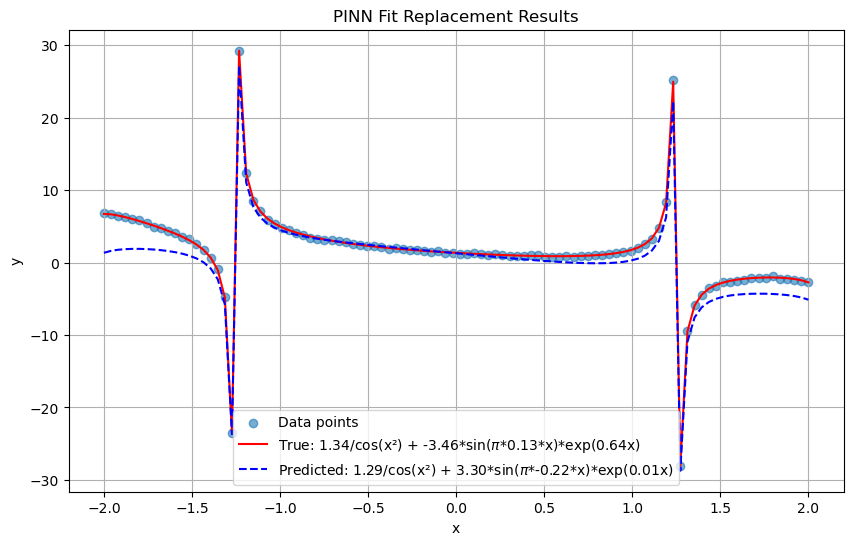

True parameters: a=-1.507, b=-6.688
Predicted parameters: a=-1.516, b=4.147, b=4.147, c=-0.224, d=0.013


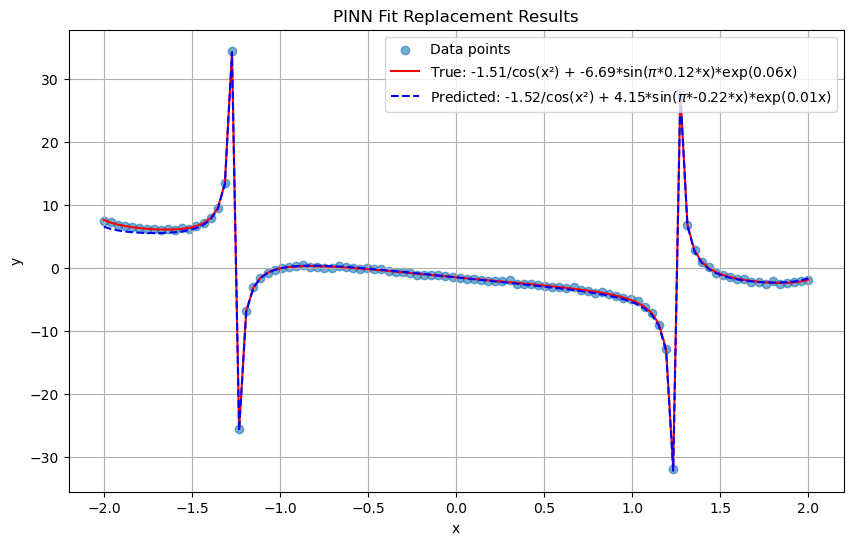

True parameters: a=-2.082, b=0.252
Predicted parameters: a=-2.092, b=-0.147, b=-0.147, c=-0.224, d=0.023


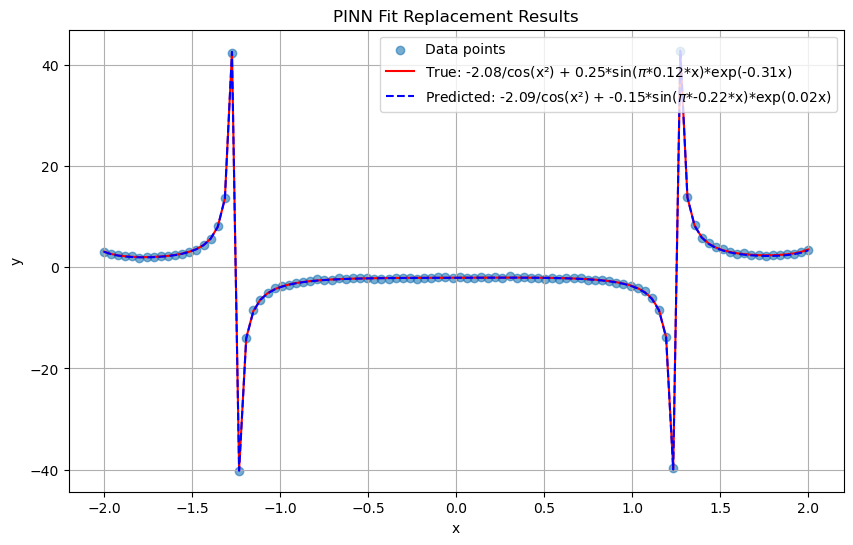

True parameters: a=-0.777, b=1.313
Predicted parameters: a=-0.788, b=0.717, b=0.717, c=-0.227, d=0.001


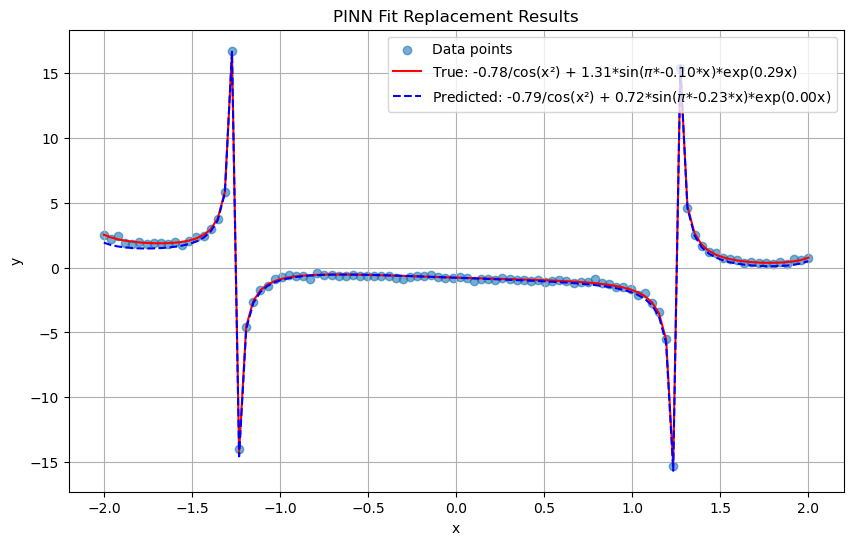

True parameters: a=4.033, b=-3.844
Predicted parameters: a=4.027, b=1.146, b=1.146, c=-0.214, d=0.043


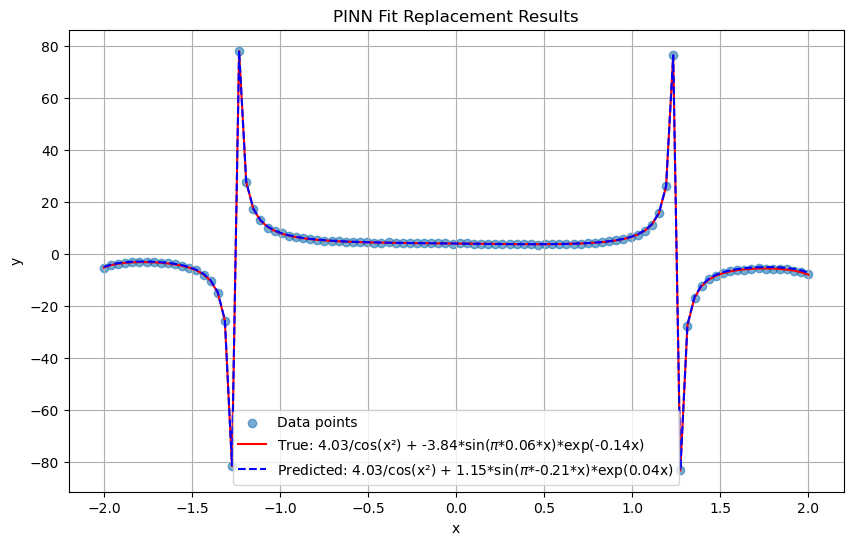

True parameters: a=-2.965, b=-6.520
Predicted parameters: a=-2.950, b=2.111, b=2.111, c=-0.214, d=0.044


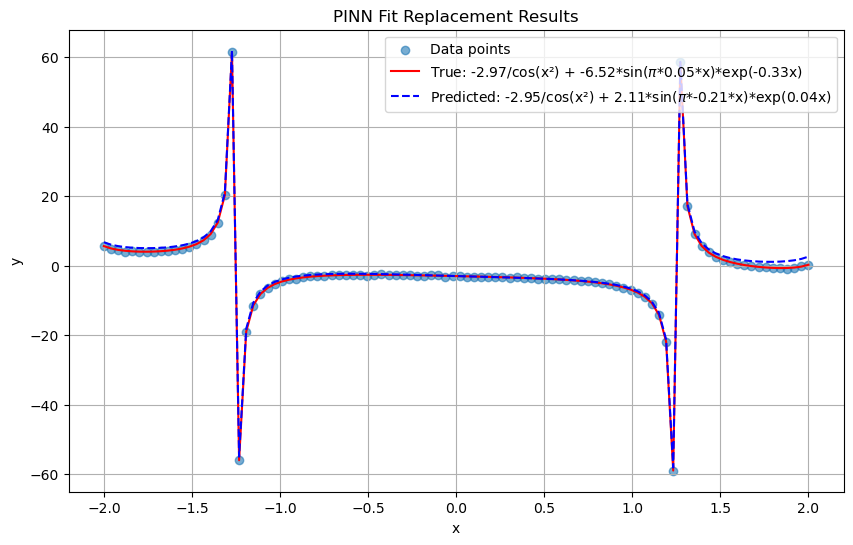

True parameters: a=-0.862, b=9.907
Predicted parameters: a=-0.917, b=-3.253, b=-3.253, c=-0.226, d=0.014


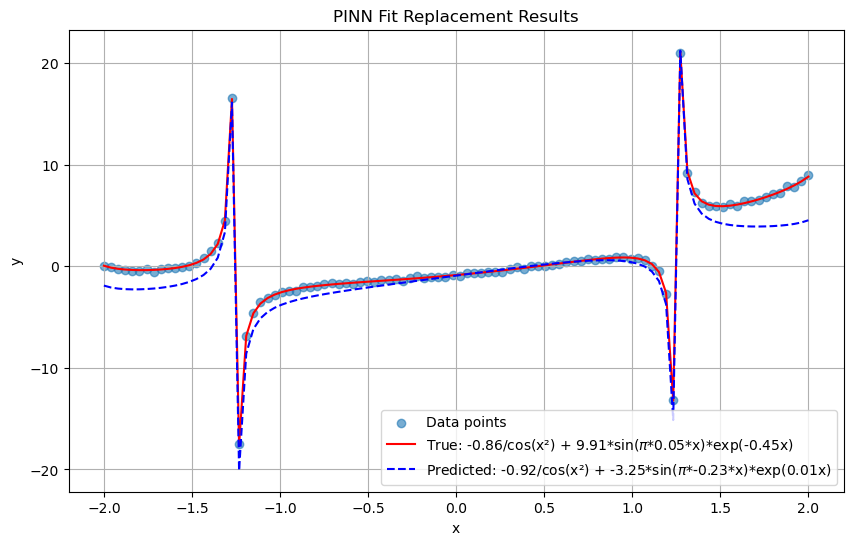

True parameters: a=-0.682, b=1.369
Predicted parameters: a=-0.688, b=0.050, b=0.050, c=-0.226, d=-0.002


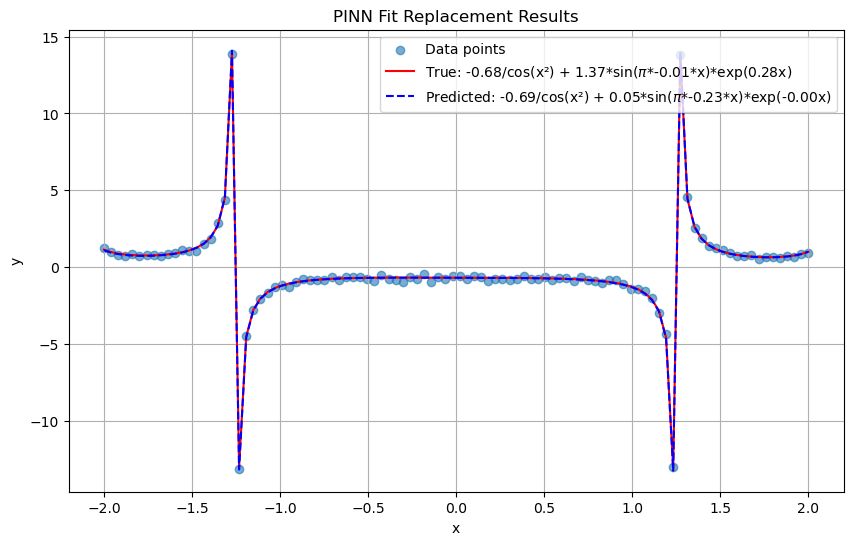

True parameters: a=-0.338, b=2.279
Predicted parameters: a=-0.342, b=0.599, b=0.599, c=-0.230, d=-0.009


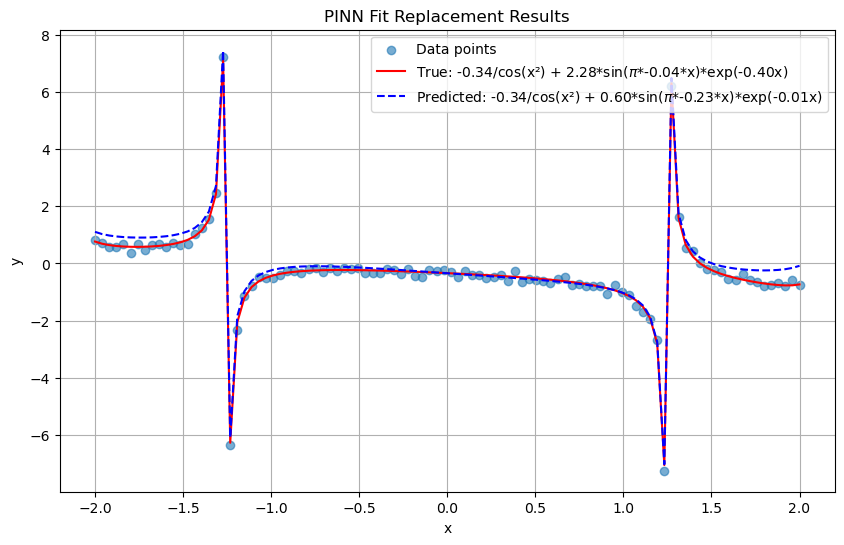

In [206]:
test_model(model=model, data_size=100, Ndata=10)